<a href="https://colab.research.google.com/github/JonathanMartignon/DeepLearningIntroduction/blob/main/ProyectoFinal/Proyecto_IAPP_2Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Proyecto: Conteo y clasificación por audio (Basado en redes convolucionales y espectogramas)

## Integrantes:
- Martiñón Luna Jonathan José
- Tapia López José de Jesús

## Licenciatura en Ciencia de Datos
## Universidad Nacional Autónoma de México 



---

# Librerías

---


In [4]:
# Colab
! pip install torchinfo
try:
    import torchaudio
except:
    ! pip install torchaudio

In [5]:
from google.colab import drive
from itertools import islice as take
import pandas as pd
import seaborn as sns
# Graficos
import matplotlib.pyplot as plt

# Audios
from scipy.io import wavfile
import librosa
import librosa.display
import IPython as ip
import random

# reproductor
import IPython as ip
# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# redes audio
import torchaudio
import torchaudio.transforms as T
# redes visión
import torchvision.models as tvm

# redes neuronales
from torch.utils.data import DataLoader
# inspección de arquitectura
from torchinfo import summary

# barras de progreso
from tqdm.auto import trange

---

# Funciones

---


In [6]:
def muestra_audio_y_espectrograma(audio, conjunto, hablantes, sample_rate = 16000, fig_size=(14,7)):
  '''
  @Autor: Jonathan Martiñón

  @Descripción:   Función encargada de obtener el audio y espectrograma
                  de un arreglo numpy. Simplemente es para mostrar en
                  el análisis de datos

  @Parámetros:

  audio           Audio a trabajar                      NUMPY.NDARRAY

  conjunto        conjunto al que pertenece el audio    STR

  hablantes       cantidad de hablantes en el audio     INT

  sample_rate     Frecuencia de muestreo                INT

  fig_size        Tamaño del gráfico                    TUPLE

  @Devuelve:      NONE

  @Ejemplo:

  -------------------------------------

  audio = np.random.normal(0, 1, size=(16000,))
  conjunto = "Entrenamiento"
  hablantes = 1
  sample_rate = 16000
  
  muestra_audio_y_espectrograma(audio, conjunto, hablantes, sample_rate = sample_rate)

  >>> # Debería mostrar 2 subplots #
  -------------------------------------
  
  '''
  # Generamos la figura que contendrá los plots
  plt.figure(figsize=fig_size)

  #----------------------
  # Graficando el audio
  #----------------------
  
  # Generamos nuestro primer subplot
  plt.subplot(1,2,1)

  # Mostramos la forma de onda con librosa
  librosa.display.waveplot(audio, sr=sample_rate)
  
  #Ajustamos el título
  plt.title(f'Audio, {conjunto} con {hablantes} hablantes')
  # Ajustamos el eje X
  plt.xlabel('tiempo')
  # Ajustamos el eje Y
  plt.ylabel('amplitud')

  #-----------------------------
  # Graficando el espectrograma
  #-----------------------------

  # Generamos nuestro segundo subplot
  plt.subplot(1,2,2)

  # Calculamos la transformada de Fourier de tiempo corto 
  # (short-time Fourier transform)
  D = librosa.stft(audio)

  # Convertimos a escala de decibeles
  S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
  # Mostramos el espectrograma con librosa
  librosa.display.specshow(S_db, sr=sample_rate)

  # Generamos el título
  plt.title(f'Espectrograma de {conjunto} con {hablantes} hablantes')
  # Ajustamos el eje x
  plt.xlabel('tiempo')
  #Ajustamos el eje y
  plt.ylabel('frecuencia')
  # Colocamos nuestra barra de colores
  cbar = plt.colorbar()
  # Indicamos de qué se trata
  cbar.set_label('magnitud', rotation=90)

  # Ajustamos los gráficos a la figura
  plt.tight_layout()
  # Mostramos la figura
  plt.show()

---

# Pre-procesamiento

---


## Carga de datos

Montamos drive, para realizar la extracción de los datos a utilizar.

In [7]:
# drive.mount('/content/drive/')

Movemos los archivos a una carpeta específica (`./Data`), para no tener que buscarlos o ingresar la dirección completa

In [8]:
#!rm -r "Data"

In [9]:
# !mkdir "./Data"
# !cp "drive/MyDrive/Intro_Ap_Prof/Proyecto/Validacion.csv" "Data"
# !cp "drive/MyDrive/Intro_Ap_Prof/Proyecto/Entrenamiento.csv" "Data"
# !cp "drive/MyDrive/Intro_Ap_Prof/Proyecto/Prueba.csv" "Data"

In [10]:
# !unzip -q "drive/My Drive/Intro_Ap_Prof/Proyecto/Audios_Prueba.zip" -d "./Data"
# !unzip -q "drive/My Drive/Intro_Ap_Prof/Proyecto/Audios_Validacion.zip" -d "./Data"
# !unzip -q "drive/My Drive/Intro_Ap_Prof/Proyecto/Audio_Entrenamiento.zip" -d "./Data"

Una vez que ya contamos con los archivos necesarios, procedemos a desmontar nuestro drive.

In [11]:
# drive.flush_and_unmount()

Damos una introducción de los datos que contamos

In [12]:
! ls -R {'Data'} | head -20

Data:
Entrenamiento
Entrenamiento.csv
Prueba
Prueba.csv
Validacion
Validacion.csv

Data/Entrenamiento:
Audio_Train0.wav
Audio_Train10000.wav
Audio_Train10001.wav
Audio_Train10002.wav
Audio_Train10003.wav
Audio_Train10004.wav
Audio_Train10005.wav
Audio_Train10006.wav
Audio_Train10007.wav
Audio_Train10008.wav
Audio_Train10009.wav


## Lectura de datos

In [13]:
entrenamiento_df = pd.read_csv("./Data/Entrenamiento.csv")
validacion_df = pd.read_csv("./Data/Validacion.csv")
prueba_df = pd.read_csv("./Data/Prueba.csv")

In [14]:
entrenamiento_df['Speakers_Class'] = entrenamiento_df['Speakers'] - 1
validacion_df['Speakers_Class'] = validacion_df['Speakers'] - 1
prueba_df['Speakers_Class'] = prueba_df['Speakers'] - 1

## Generamos nuestro DATA LOADER

In [15]:
# directorio de datos
DATA_DIR = 'Data'

# tamaño del lote
BATCH_SIZE = 32

# parámetros de audio
SECS = 1
SAMPLE_RATE = 16000

#Tamaño de la ventana
N_FFT = 400
#Longitud del salto
HOP_LENGTH = N_FFT // 2

# Ajustamos las clases
CLASSES = ('1','2','3')

# Diccionario de clases
CLASS_IDX = {c: i for i, c in enumerate(CLASSES)}

# El número de clases
NUM_CLASSES = len(CLASSES)

# Para reproducibilidad ajustamos la semilla
def set_seed(seed=2209):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# reproducibilidad
set_seed()



In [1]:
class Audios:

    def __init__(self, subset, dataframe, cantidad_datos, sample_rate,n_fft,hop_length):
        
        # Almacenamos la ruta acorte al conjunto de datos
        self.subset = 'Data/'+subset
        # Alamacenamos la frecuencia de muestreo
        self.sample_rate = sample_rate
        # Almacenamos la cantidad de datos
        self.cantidad_datos = cantidad_datos
        # Almacenamos nuestra ventana
        self.n_fft = n_fft
        # Almacenamos nuestro salto
        self.hop_length = hop_length
        
        # En caso de que nuestro conjunto sea  Entrenamiento ajustamos la ruta de lectura
        if self.subset == 'Data/Entrenamiento':
          self.read = self.subset + '/Audio_Train'
          
        # En caso de que nuestro conjunto sea Validación ajustamos la ruta de lectura
        elif self.subset == 'Data/Validacion':
          self.read = self.subset + '/Audio_Validation'
        
        # En otro caso asumiremos que nuestro conjunto será Prueba, por lo que ajustamos la ruta de lectura
        else:
          self.read = self.subset+'/Audio_Test'

        # Una vez obtenida la ruta, procedemos con la lectura de los audios
        self.audios = [wavfile.read(self.read+str(i)+'.wav')[1].reshape(1,-1) for i in range(self.cantidad_datos)]
        
        # leemos el df que contiene a los metadatos
        self.df = dataframe

        # guardamos nuestra clase correspondiente al numero de hablantes como lista de enteros
        self.speakers_class = self.df['Speakers_Class'].tolist()

    def __getitem__(self, i):
        # cargamos el audio
        self.audio_i = torch.tensor(self.audios[i])

        # Generamos su respectivo espectograma
        self.spectogram = T.Spectrogram(n_fft=self.n_fft, hop_length=self.hop_length)(self.audio_i)

        # Convertimos su amplitud a Decibeles
        self.log_spectrogram = librosa.amplitude_to_db(self.spectogram)

        # cargamos sus metadatos

        # guardamos numero de hablantes como int
        self.speakers_class_i = self.speakers_class[i]

        # Devolvemos los datos generados
        return self.log_spectrogram, self.speakers_class_i

    def __len__(self):
        # regresamos numeros de ejemplos
        return len(self.audios)


### Cargador de datos

In [17]:
def build_dl(subset, dataframe, n_datos ,n_ff,hop_length, 
             SAMPLE_RATE=16000, BATCH_SIZE=32, shuffle=False):

   # creamos un Dataset
    ds = Audios(
        subset, #subconjunto de datos
        dataframe, # DF Del conjunto seleccionado
        n_datos, # cantidad de datos del subconjunto
        SAMPLE_RATE, # en todos es de 16000
        n_ff, # Tamaño de la ventana
        hop_length # Tamaño del salto
        )

    # creamos un DataLoader
    dl = DataLoader(
        # conjunto
        ds,
        # tamaño del lote
        batch_size=BATCH_SIZE,
        # barajear
        shuffle=shuffle,
    )
    return dl

x shape=torch.Size([32, 1, 201, 81]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64



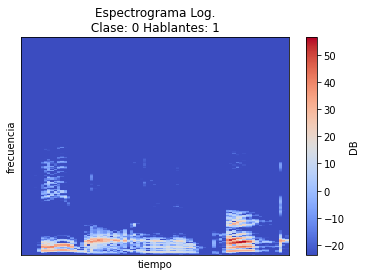

In [18]:
# Llamamos nuestro constructor del data loader
dl = build_dl(subset='Validacion', dataframe = validacion_df,n_datos=10000 ,
              n_ff = N_FFT, hop_length=HOP_LENGTH)

# desplegamos un lote de audios
x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
print()
# inspeccionemos un ejemplo
waveform = x[0].squeeze().numpy()
label = y[0]

librosa.display.specshow(waveform, 
                         sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plt.title(f'Espectrograma Log.\n Clase: {label} Hablantes: {label+1} ')
plt.xlabel('tiempo')
plt.ylabel('frecuencia')
cbar = plt.colorbar()
cbar.set_label('DB', rotation=90)
plt.show()

# Diseño de Entrenamiento

In [19]:
def train_epoch(dl, model, opt, device):

    # por cada lote
    for x, y_true, *_ in dl:

        # movemos a dispositivo
        x = x.to(device)
        y_true = y_true.to(device)

        # computamos logits
        y_lgts = model(x)

        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)

        # vaciamos los gradientes
        opt.zero_grad()

        # retropropagamos
        loss.backward()

        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, device, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true, *_ in take(dl, num_batches):

            # movemos a dispositivo
            x = x.to(device)
            y_true = y_true.to(device)

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-4, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.Adam(model.parameters(), lr=lr)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # modelo en modo de entrenamiento
        model.train()
        # entrenamos la época
        train_epoch(trn_dl, model, opt, device)

        # modelo en modo de evaluación
        model.eval()
        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, device, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, device, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

---

# Modelado

---


In [34]:
class CNN(nn.Module):

    def __init__(self, n_in_channels=1, n_classes=NUM_CLASSES, n_channel=32):
        super().__init__()

        self.cnn = nn.Sequential(

             # bloque conv 1
            nn.Conv2d(in_channels=n_in_channels, 
                      out_channels=n_channel,
                      kernel_size=3),
            nn.BatchNorm2d(n_channel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Se agregó droput
            nn.Dropout(p=0.2),

            # bloque conv 2
            nn.Conv2d(in_channels=n_channel, 
                      out_channels=n_channel, 
                      kernel_size=3),
            nn.BatchNorm2d(num_features=n_channel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Se agregó droput
            nn.Dropout(p=0.4),

        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(n_channel, n_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = self.pool(x)
        x = self.flat(x)
        x = self.fc(x)
        return x
    
def build_cnn():
    return CNN()

cnn = build_cnn()
cnn

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.4, inplace=False)
  )
  (pool): AdaptiveAvgPool2d(output_size=1)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

In [35]:
x = torch.zeros(1, 1, 201, 81)
y = cnn(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 1, 201, 81]) => torch.Size([1, 3])


In [36]:
summary(cnn, (1, 1, 201, 81), device='cpu', verbose=0,
        col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CNN                                      --                        --                        --
├─Sequential: 1-1                        [1, 1, 201, 81]           [1, 32, 48, 18]           --
│    └─Conv2d: 2-1                       [1, 1, 201, 81]           [1, 32, 199, 79]          320
│    └─BatchNorm2d: 2-2                  [1, 32, 199, 79]          [1, 32, 199, 79]          64
│    └─ReLU: 2-3                         [1, 32, 199, 79]          [1, 32, 199, 79]          --
│    └─MaxPool2d: 2-4                    [1, 32, 199, 79]          [1, 32, 99, 39]           --
│    └─Dropout: 2-5                      [1, 32, 99, 39]           [1, 32, 99, 39]           --
│    └─Conv2d: 2-6                       [1, 32, 99, 39]           [1, 32, 97, 37]           9,248
│    └─BatchNorm2d: 2-7                  [1, 32, 97, 37]           [1, 32, 97, 37]           64
│    └─ReLU: 2-8               

# Entrenamiento

In [37]:

def train_model(build_model,n_fft,hop_length, lr=1e-4, epochs=10):
    set_seed()
    trn_dl = build_dl(subset='Entrenamiento', dataframe = entrenamiento_df,n_datos=100000 ,
              n_ff = n_fft, hop_length=hop_length)
    
    val_dl = build_dl(subset='Validacion', dataframe = validacion_df,n_datos=10000 ,
              n_ff = n_fft, hop_length=hop_length)

    model = build_model()


    loss_hist, acc_hist = train(
        model, trn_dl, val_dl, lr=lr, epochs=epochs)
    
    return loss_hist, acc_hist, model

In [38]:
loss_hist, acc_hist, model = train_model(build_model=build_cnn, n_fft=N_FFT, hop_length=HOP_LENGTH)

E00 loss=[ 85.85, 90.03] acc=[60.69,57.91]
E01 loss=[ 80.61, 84.62] acc=[63.78,60.32]
E02 loss=[ 77.41, 81.12] acc=[65.22,61.66]
E03 loss=[ 75.35, 78.91] acc=[66.16,62.66]
E04 loss=[ 73.82, 77.11] acc=[66.79,63.65]
E05 loss=[ 72.68, 75.95] acc=[67.33,64.29]
E06 loss=[ 71.93, 75.45] acc=[67.61,64.21]
E07 loss=[ 71.17, 74.41] acc=[68.08,64.93]
E08 loss=[ 70.62, 74.00] acc=[68.26,65.10]
E09 loss=[ 69.95, 73.34] acc=[68.57,65.50]



---

# Resultados

---


In [39]:
data_plot = pd.DataFrame({"Loss_Train":np.array(loss_hist)[:,0],
                          "Loss_Eval":np.array(loss_hist)[:,1],
                          "Acc_Train":np.array(acc_hist)[:,0],
                          "Acc_Eval":np.array(acc_hist)[:,1]})

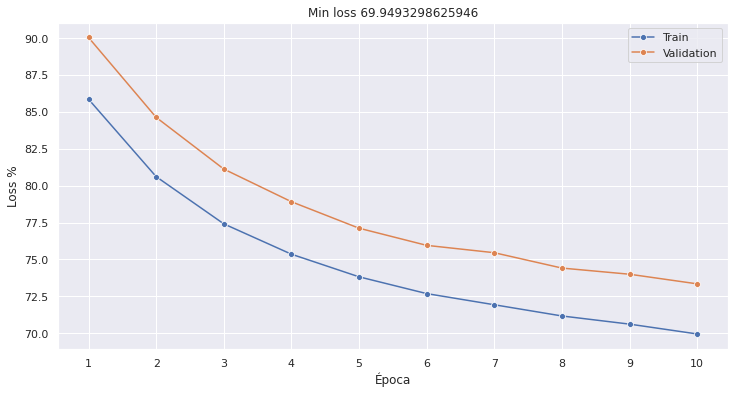

In [40]:
x = np.arange(1,11,1)
sns.set_theme()

plt.figure(figsize=(12,6))
sns.lineplot(data=data_plot,x = x, y="Loss_Train",marker='o')
sns.lineplot(data=data_plot,x = x, y="Loss_Eval",marker='o')
plt.xticks(x)
plt.ylabel("Loss %")
plt.title(f"Min loss {min(min(np.array(loss_hist)[:,0]),min(np.array(loss_hist)[:,1]))}")
plt.xlabel("Época")
plt.legend(labels=["Train","Validation"])
plt.show()

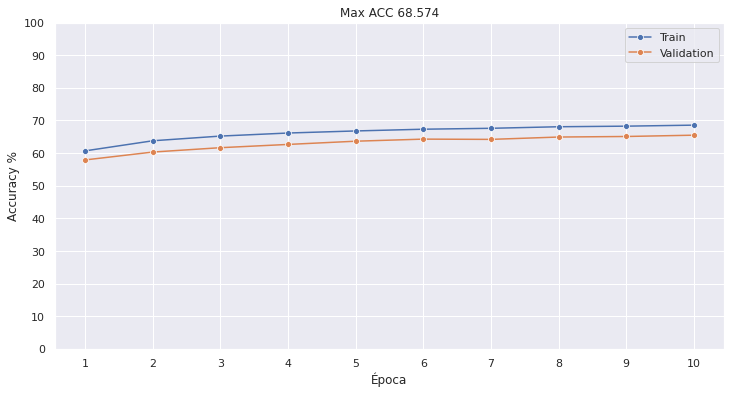

In [41]:
x = np.arange(1,11,1)
plt.figure(figsize=(12,6))
sns.lineplot(data=data_plot,x = x, y="Acc_Train",marker='o')
sns.lineplot(data=data_plot,x = x, y="Acc_Eval",marker='o')
plt.ylabel("Accuracy %")
plt.xticks(x)
plt.title(f"Max ACC {max(max(np.array(acc_hist)[:,0]),max(np.array(acc_hist)[:,1]))}")
plt.xlabel("Época")
plt.legend(["Train","Validation"])
plt.yticks(np.arange(0,110,10))
plt.show()

# Probando el modelo

In [42]:
def display_batch(xs, titles, rows, cols, figsize=(16, 10), SAMPLE_RATE=16000):
    """Desplegamos ejemplos en una malla."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    
    i = 0
    for r in range(rows):
        for c in range(cols):
            x = xs.to(torch.device("cpu"))
            librosa.display.specshow(x[i].squeeze().numpy(), 
                         sr=SAMPLE_RATE, hop_length=HOP_LENGTH,ax=ax[r,c])
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            ax[r, c].set_xlabel('')
            i += 1
    fig.tight_layout()
    plt.show()

In [43]:
tst_dl = build_dl(subset='Prueba', dataframe = prueba_df,n_datos=10000 ,
              n_ff = N_FFT, hop_length=HOP_LENGTH)

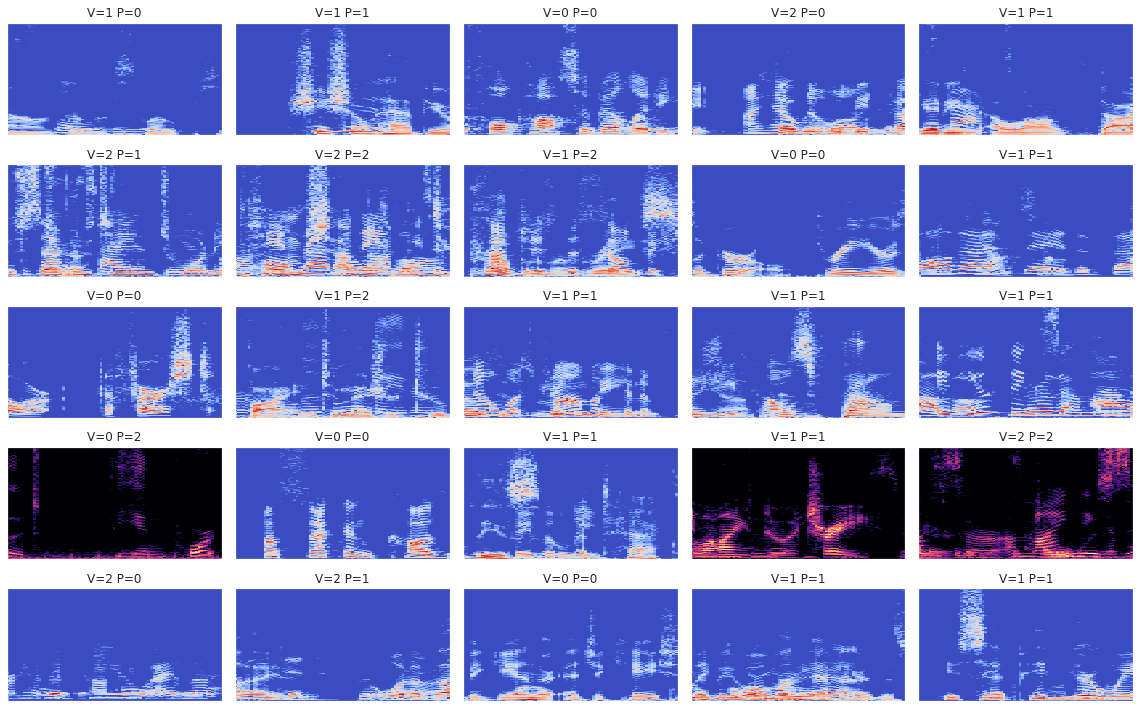

In [44]:
with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = x.to(device)
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, 5, 5)